In [1]:
########################################
## import packages
########################################

import datetime
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Reshape
from keras.layers.merge import concatenate, dot
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD

Using TensorFlow backend.


In [2]:
########################################
## load the data
########################################

train = pd.read_csv('./data/train.csv')
uid = train.msno
sid = train.song_id
target = train.target

test = pd.read_csv('./data/test.csv')
id_test = test.id
uid_test = test.msno
sid_test = test.song_id

In [3]:
########################################
## encoding
########################################

usr_encoder = LabelEncoder()
usr_encoder.fit(uid.append(uid_test))
uid = usr_encoder.transform(uid)
uid_test = usr_encoder.transform(uid_test)

sid_encoder = LabelEncoder()
sid_encoder.fit(sid.append(sid_test))
sid = sid_encoder.transform(sid)
sid_test = sid_encoder.transform(sid_test)

u_cnt = int(max(uid.max(), uid_test.max()) + 1)
s_cnt = int(max(sid.max(), sid_test.max()) + 1)

########################################
## train-validation split
########################################

perm = np.random.permutation(len(train))
trn_cnt = int(len(train) * 0.85)
uid_trn = uid[perm[:trn_cnt]]
uid_val = uid[perm[trn_cnt:]]
sid_trn = sid[perm[:trn_cnt]]
sid_val = sid[perm[trn_cnt:]]
target_trn = target[perm[:trn_cnt]]
target_val = target[perm[trn_cnt:]]

In [4]:
########################################
## define the model
########################################

def get_model():
    user_embeddings = Embedding(u_cnt,
            64,
            embeddings_initializer=RandomUniform(minval=-0.1, maxval=0.1),
            embeddings_regularizer=l2(1e-4),
            input_length=1,
            trainable=True)
    song_embeddings = Embedding(s_cnt,
            64,
            embeddings_initializer=RandomUniform(minval=-0.1, maxval=0.1),
            embeddings_regularizer=l2(1e-4),
            input_length=1,
            trainable=True)

    uid_input = Input(shape=(1,), dtype='int32')
    embedded_usr = user_embeddings(uid_input)
    embedded_usr = Reshape((64,))(embedded_usr)

    sid_input = Input(shape=(1,), dtype='int32')
    embedded_song = song_embeddings(sid_input)
    embedded_song = Reshape((64,))(embedded_song)

    preds = dot([embedded_usr, embedded_song], axes=1)
    preds = concatenate([embedded_usr, embedded_song, preds])
    
    preds = Dense(128, activation='relu')(preds)
    preds = Dropout(0.5)(preds)
    
    preds = Dense(1, activation='sigmoid')(preds)

    model = Model(inputs=[uid_input, sid_input], outputs=preds)
    
    opt = RMSprop(lr=1e-3)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

    return model

In [5]:
# print model
model = get_model()
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 64)         2201792     input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 64)         26869696    input_2[0][0]                    
___________________________________________________________________________________________

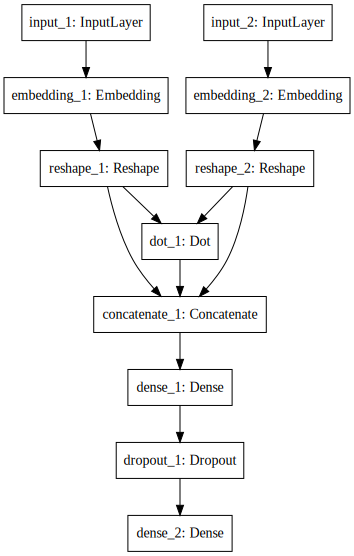

In [10]:
# Model visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
########################################
## train the model
########################################
early_stopping =EarlyStopping(monitor='val_acc', patience=5)
model_path = 'bst_model.h5'
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, \
        save_weights_only=True)

hist = model.fit([uid_trn, sid_trn], target_trn, validation_data=([uid_val, sid_val], \
        target_val), epochs=10, batch_size=32768, shuffle=True, \
        callbacks=[early_stopping, model_checkpoint])
model.load_weights(model_path)

preds_val = model.predict([uid_val, sid_val], batch_size=32768)
val_auc = roc_auc_score(target_val, preds_val)

########################################
## make the submission
########################################

preds_test = model.predict([uid_test, sid_test], batch_size=32768, verbose=1)
sub = pd.DataFrame({'id': id_test, 'target': preds_test.ravel()})
sub.to_csv('./sub_%.5f.csv'%(val_auc), index=False)

Train on 6270805 samples, validate on 1106613 samples
Epoch 1/10
6270805/6270805 [==============================] - 155s - loss: 1.7466 - acc: 0.6381 - val_loss: 0.6354 - val_acc: 0.6632
Epoch 2/10
6270805/6270805 [==============================] - 146s - loss: 0.6272 - acc: 0.6670 - val_loss: 0.6209 - val_acc: 0.6692
Epoch 3/10
6270805/6270805 [==============================] - 148s - loss: 0.6184 - acc: 0.6715 - val_loss: 0.6166 - val_acc: 0.6713
Epoch 4/10
6270805/6270805 [==============================] - 146s - loss: 0.6148 - acc: 0.6744 - val_loss: 0.6132 - val_acc: 0.6744
Epoch 5/10
6270805/6270805 [==============================] - 147s - loss: 0.6113 - acc: 0.6788 - val_loss: 0.6101 - val_acc: 0.6795
Epoch 6/10
6270805/6270805 [==============================] - 146s - loss: 0.6091 - acc: 0.6825 - val_loss: 0.6083 - val_acc: 0.6822
Epoch 7/10
6270805/6270805 [==============================] - 148s - loss: 0.6074 - acc: 0.6851 - val_loss: 0.6069 - val_acc: 0.6842
Epoch 8/10
6270